In [1]:
import sys
import os
# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:
# Loading Config
from utils.config import load_yaml_config, merge_configs, dict_to_namespace
import numpy as np

default_yaml = "../utils/configs/default.yaml"
problem_yaml = "../utils/configs/problem_3.yaml"
category_yaml = "../utils/configs/experiment_trnc_c.yaml"

custom_config_files = [default_yaml, problem_yaml, category_yaml] # Add more config files if needed
configs = [load_yaml_config(config_file) for config_file in custom_config_files]
yaml = merge_configs(*configs)

## Here you can modify the yaml object to change the configuration
## Example: yaml.seed = 123, yaml.max_num_tasks = 10
config = dict_to_namespace(yaml)

In [3]:
import torch
import random

# Set random seeds for reproducibility

random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)

In [4]:
# config.invalid_action_replacement = True

In [5]:
config.train = False
config.evaluate = True

In [6]:
from env.cades_env import CadesEnv
from stable_baselines3.common.env_checker import check_env

#xs Initialize and check the environment
env = CadesEnv(config)
check_env(env)

/home/ediss5/anaconda3/envs/cades/lib/python3.9/site-packages/stable_baselines3/common/env_checker.py:190: UserWarning: Your observation communications has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [7]:
from models.ppo import PPOModel

#model = PPOModel.load("../mlruns/802427248900867940/f9b407a202b84f53be918f8c487d9c32/artifacts/models/best_model", env, config)
model = PPOModel.load("../../experiments/models/p3/trnc_c/early_term_1000", env, config)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [8]:
from env.extended_states_generator import ExtendedStatesGenerator
import copy

def change_states(env, num_tasks):
    
    new_config = copy.deepcopy(config)
    new_config.max_num_tasks = num_tasks
    new_config.min_num_tasks = num_tasks
    if num_tasks < 2:
        new_config.min_num_comms = 0
        new_config.max_num_comms = 0
    else:
        new_config.min_num_comms = num_tasks // 2
        new_config.max_num_comms = num_tasks // 2
        new_config.max_comm_chain = config.min_node_size // config.min_task_size
    if num_tasks < 3:
        new_config.number_of_critical_tasks = 0
        new_config.number_of_replicas = 0
    else:
        new_config.number_of_critical_tasks = num_tasks // 4
        new_config.number_of_replicas = 2
    old_generator = env.states_generator
    env.states_generator = ExtendedStatesGenerator(new_config)
    # Use the new state generator to generate the states
    states = env.generate_states(training=False)

    if(env.config.max_num_tasks != env.states_generator.max_num_tasks): # If the state generator did not generate the maximum number of tasks
        ## Pad the states to the maximum number of tasks
        indices_to_pad = env.config.max_num_tasks - env.states_generator.max_num_tasks
        padded_tasks = np.pad(states['tasks'], (0, indices_to_pad), mode='constant')
        padded_critical_mask = np.pad(states['critical_mask'], (0, indices_to_pad), mode='constant')
        padded_communications = np.pad(states['communications'], ((0, indices_to_pad), (0, indices_to_pad)), mode='constant')
        states['tasks'] = padded_tasks
        states['critical_mask'] = padded_critical_mask
        states['communications'] = padded_communications
    
    # Restore the old state generator
    env.states_generator = old_generator
    return states

In [9]:
episodes = 100
global_states = {}
for num_tasks in range(1, env.config.max_num_tasks + 1):
    for num_episode in range(episodes): # 100 episode states for each number of tasks
        states = change_states(env, num_tasks)
        global_states[(num_tasks, num_episode)] = states

In [10]:
# Warm up the model
warmup = model.evaluate(states=global_states[(1, 0)])
print(f"Warm up took {warmup['inference_time'] * 1000} milliseconds")

Warm up took 632.1656703948975 milliseconds


In [11]:
def evaluate_model(model, num_tasks, states, heuristic=None):
    results = {
        'success': 0, 
        'inference_time': 0, 
        'avg_active_node_occupancy': 0,
        'message_channel_occupancy': 0,
        'empty_nodes': 0
    }
    for num_episode in range(episodes):
        if heuristic is not None:
            heuristic.set_state(states[(num_tasks, num_episode)])
        result = model.evaluate(states=states[(num_tasks, num_episode)])
        if result['termination_cause'] == 'success':
            results['success'] += 1
        results['inference_time'] += result['inference_time']
        results['avg_active_node_occupancy'] += result['metrics']['avg_active_node_occupancy']
        results['message_channel_occupancy'] += result['metrics']['message_channel_occupancy']
        results['empty_nodes'] += result['metrics']['empty_nodes']
        # print(f"Episode {num_episode + 1} completed, Success: {result['termination_cause']}, Inference Time: {round(result['inference_time'] * 1000, 2)}, Avg Active Node Occupancy: {result['metrics']['avg_active_node_occupancy']}, Message Channel Occupancy: {result['metrics']['message_channel_occupancy']}, Empty Nodes: {result['metrics']['empty_nodes']}")
    # Average the rewards

    results['success'] = round(results['success'] / episodes * 100, 2)
    results['inference_time'] = round(results['inference_time'] / episodes * 1000, 2)
    results['avg_active_node_occupancy'] = round(results['avg_active_node_occupancy'] / episodes, 2)
    results['message_channel_occupancy'] = round(results['message_channel_occupancy'] / episodes, 2)
    results['empty_nodes'] = round(results['empty_nodes'] / episodes, 2)
    return results

In [12]:
model_predict = model.model.predict

In [13]:
import pandas as pd
metrics = pd.DataFrame(columns=['ppo', 'ffd', 'nf', 'ff'])
model.model.predict = model_predict
values = []

for num_tasks in range(1, env.config.max_num_tasks + 1):
    result = evaluate_model(model, num_tasks, global_states)
    values.append(result)
    print(f"Number of tasks: {num_tasks}, Inference Time: {result['inference_time']} ms, Success Rate: {result['success']}, Avg Active Node Occupancy: {result['avg_active_node_occupancy']}, Message Channel Occupancy: {result['message_channel_occupancy']}, Empty Nodes: {result['empty_nodes']}")
    
metrics['ppo'] = values

Number of tasks: 1, Inference Time: 1.36 ms, Success Rate: 100.0, Avg Active Node Occupancy: 43.28, Message Channel Occupancy: 0.0, Empty Nodes: 85.5
Number of tasks: 2, Inference Time: 2.7 ms, Success Rate: 100.0, Avg Active Node Occupancy: 44.04, Message Channel Occupancy: 100.0, Empty Nodes: 71.16
Number of tasks: 3, Inference Time: 4.06 ms, Success Rate: 100.0, Avg Active Node Occupancy: 43.5, Message Channel Occupancy: 100.0, Empty Nodes: 56.61
Number of tasks: 4, Inference Time: 5.4 ms, Success Rate: 100.0, Avg Active Node Occupancy: 44.94, Message Channel Occupancy: 99.5, Empty Nodes: 41.98
Number of tasks: 5, Inference Time: 6.7 ms, Success Rate: 99.0, Avg Active Node Occupancy: 44.06, Message Channel Occupancy: 99.5, Empty Nodes: 28.8
Number of tasks: 6, Inference Time: 8.1 ms, Success Rate: 100.0, Avg Active Node Occupancy: 45.47, Message Channel Occupancy: 100.0, Empty Nodes: 13.7
Number of tasks: 7, Inference Time: 9.39 ms, Success Rate: 99.0, Avg Active Node Occupancy: 48.

In [14]:
# redefine model's predict method to use the heuristic
from heuristics.ffd import FirstFitDecreasingHeuristic
heuristic = FirstFitDecreasingHeuristic(env)
model.model.predict = heuristic.predict

values = []

for num_tasks in range(1, env.config.max_num_tasks + 1):
    result = evaluate_model(model, num_tasks, global_states, heuristic)
    values.append(result)
    print(f"Number of tasks: {num_tasks}, Inference Time: {result['inference_time']} ms, Success Rate: {result['success']}, Avg Active Node Occupancy: {result['avg_active_node_occupancy']}, Message Channel Occupancy: {result['message_channel_occupancy']}, Empty Nodes: {result['empty_nodes']}")

metrics['ffd'] = values

Number of tasks: 1, Inference Time: 0.11 ms, Success Rate: 100.0, Avg Active Node Occupancy: 45.61, Message Channel Occupancy: 0.0, Empty Nodes: 85.5
Number of tasks: 2, Inference Time: 0.21 ms, Success Rate: 100.0, Avg Active Node Occupancy: 79.68, Message Channel Occupancy: 22.0, Empty Nodes: 82.27
Number of tasks: 3, Inference Time: 0.26 ms, Success Rate: 100.0, Avg Active Node Occupancy: 66.23, Message Channel Occupancy: 71.0, Empty Nodes: 70.41
Number of tasks: 4, Inference Time: 0.39 ms, Success Rate: 100.0, Avg Active Node Occupancy: 59.94, Message Channel Occupancy: 83.5, Empty Nodes: 55.34
Number of tasks: 5, Inference Time: 0.42 ms, Success Rate: 100.0, Avg Active Node Occupancy: 70.77, Message Channel Occupancy: 82.5, Empty Nodes: 53.78
Number of tasks: 6, Inference Time: 0.53 ms, Success Rate: 100.0, Avg Active Node Occupancy: 79.6, Message Channel Occupancy: 81.0, Empty Nodes: 49.51
Number of tasks: 7, Inference Time: 0.54 ms, Success Rate: 100.0, Avg Active Node Occupancy

In [15]:
# redefine model's predict method to use the heuristic
from heuristics.ff import FirstFitHeuristic
heuristic = FirstFitHeuristic(env)
model.model.predict = heuristic.predict

values = []

for num_tasks in range(1, env.config.max_num_tasks + 1):
    result = evaluate_model(model, num_tasks, global_states, heuristic)
    values.append(result)
    print(f"Number of tasks: {num_tasks}, Inference Time: {result['inference_time']} ms, Success Rate: {result['success']}, Avg Active Node Occupancy: {result['avg_active_node_occupancy']}, Message Channel Occupancy: {result['message_channel_occupancy']}, Empty Nodes: {result['empty_nodes']}")

metrics['ff'] = values

Number of tasks: 1, Inference Time: 0.11 ms, Success Rate: 100.0, Avg Active Node Occupancy: 45.61, Message Channel Occupancy: 0.0, Empty Nodes: 85.5
Number of tasks: 2, Inference Time: 0.2 ms, Success Rate: 100.0, Avg Active Node Occupancy: 79.64, Message Channel Occupancy: 22.0, Empty Nodes: 82.27
Number of tasks: 3, Inference Time: 0.25 ms, Success Rate: 100.0, Avg Active Node Occupancy: 66.23, Message Channel Occupancy: 71.0, Empty Nodes: 70.41
Number of tasks: 4, Inference Time: 0.39 ms, Success Rate: 100.0, Avg Active Node Occupancy: 59.11, Message Channel Occupancy: 84.5, Empty Nodes: 54.67
Number of tasks: 5, Inference Time: 0.41 ms, Success Rate: 100.0, Avg Active Node Occupancy: 70.89, Message Channel Occupancy: 80.5, Empty Nodes: 54.25
Number of tasks: 6, Inference Time: 0.53 ms, Success Rate: 100.0, Avg Active Node Occupancy: 75.04, Message Channel Occupancy: 81.67, Empty Nodes: 46.42
Number of tasks: 7, Inference Time: 0.56 ms, Success Rate: 100.0, Avg Active Node Occupanc

In [16]:
# redefine model's predict method to use the heuristic
from heuristics.nf import NextFitHeuristic
heuristic = NextFitHeuristic(env)
model.model.predict = heuristic.predict

values = []

for num_tasks in range(1, env.config.max_num_tasks + 1):
    result = evaluate_model(model, num_tasks, global_states, heuristic)
    values.append(result)
    print(f"Number of tasks: {num_tasks}, Inference Time: {result['inference_time']} ms, Success Rate: {result['success']}, Avg Active Node Occupancy: {result['avg_active_node_occupancy']}, Message Channel Occupancy: {result['message_channel_occupancy']}, Empty Nodes: {result['empty_nodes']}")

metrics['nf'] = values

Number of tasks: 1, Inference Time: 0.1 ms, Success Rate: 100.0, Avg Active Node Occupancy: 45.61, Message Channel Occupancy: 0.0, Empty Nodes: 85.5
Number of tasks: 2, Inference Time: 0.2 ms, Success Rate: 100.0, Avg Active Node Occupancy: 79.64, Message Channel Occupancy: 22.0, Empty Nodes: 82.27
Number of tasks: 3, Inference Time: 0.24 ms, Success Rate: 100.0, Avg Active Node Occupancy: 65.64, Message Channel Occupancy: 70.0, Empty Nodes: 70.08
Number of tasks: 4, Inference Time: 0.37 ms, Success Rate: 100.0, Avg Active Node Occupancy: 58.13, Message Channel Occupancy: 88.0, Empty Nodes: 53.74
Number of tasks: 5, Inference Time: 0.4 ms, Success Rate: 100.0, Avg Active Node Occupancy: 66.99, Message Channel Occupancy: 83.0, Empty Nodes: 51.2
Number of tasks: 6, Inference Time: 0.51 ms, Success Rate: 98.0, Avg Active Node Occupancy: 67.57, Message Channel Occupancy: 88.33, Empty Nodes: 41.24
Number of tasks: 7, Inference Time: 0.54 ms, Success Rate: 97.0, Avg Active Node Occupancy: 70

In [27]:
metrics['ppo'].apply(lambda x: f"{x['inference_time']}")

0     1.36
1      2.7
2     4.06
3      5.4
4      6.7
5      8.1
6     9.39
7    10.64
8    12.07
9    13.16
Name: ppo, dtype: object

In [28]:
metrics['ffd'].apply(lambda x: f"{x['inference_time']}")

0    0.11
1    0.21
2    0.26
3    0.39
4    0.42
5    0.53
6    0.54
7    0.65
8    0.68
9    0.79
Name: ffd, dtype: object

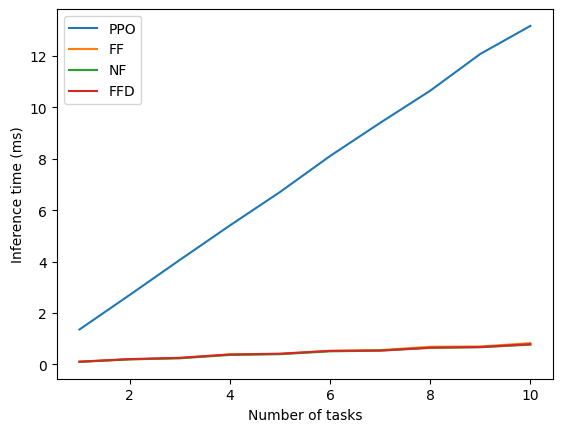

In [33]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['inference_time'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['inference_time'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['inference_time'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['inference_time'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Inference time (ms)')
plt.legend()
plt.show()

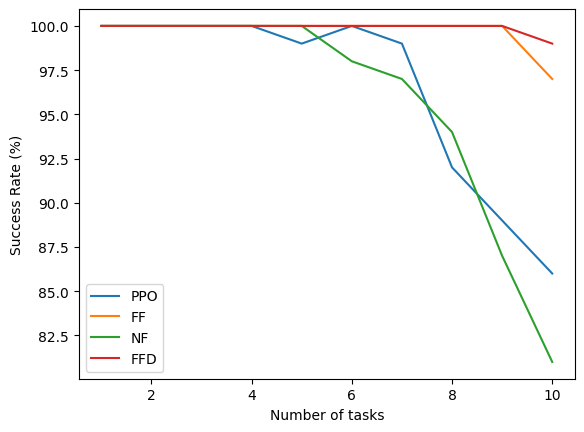

In [34]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['success'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['success'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['success'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['success'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Success Rate (%)')
plt.legend()
plt.show()

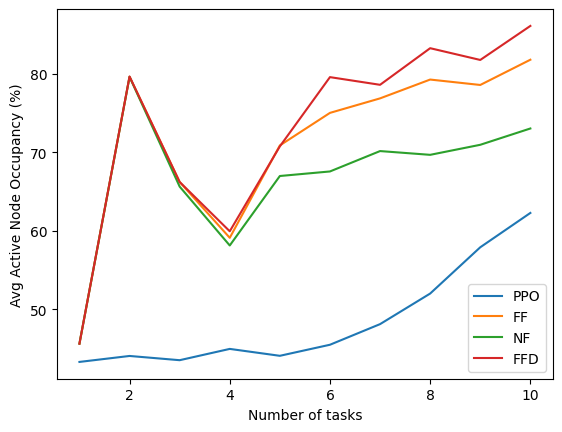

In [37]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['avg_active_node_occupancy'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['avg_active_node_occupancy'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['avg_active_node_occupancy'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['avg_active_node_occupancy'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Avg Active Node Occupancy (%)')
plt.legend()
plt.show()

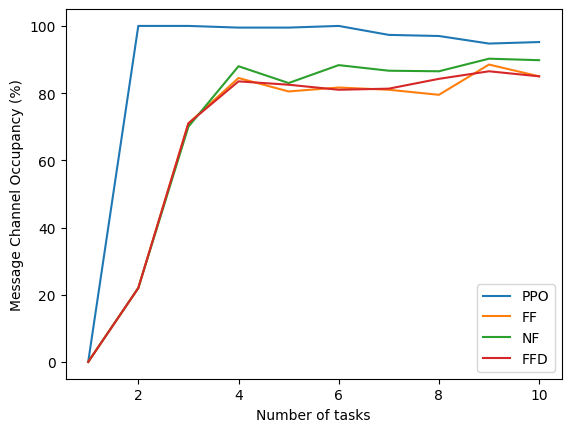

In [38]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['message_channel_occupancy'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['message_channel_occupancy'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['message_channel_occupancy'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['message_channel_occupancy'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Message Channel Occupancy (%)')
plt.legend()
plt.show()

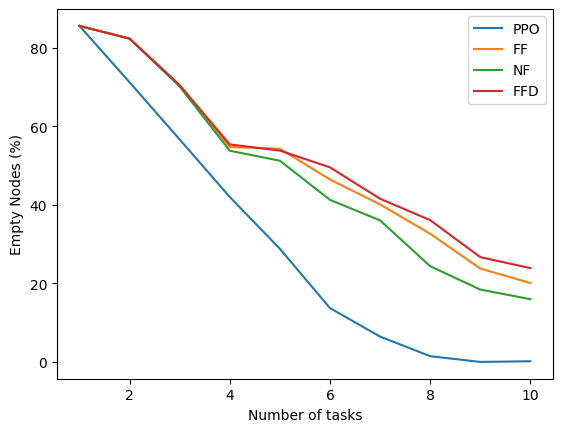

In [39]:
# Plot the success rate graph
import matplotlib.pyplot as plt

plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ppo'].apply(lambda x: float(x['empty_nodes'])), label='PPO')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['ff'].apply(lambda x: float(x['empty_nodes'])), label='FF')
plt.plot(range(1, 1 + len(metrics['ppo'])), metrics['nf'].apply(lambda x: float(x['empty_nodes'])), label='NF')
plt.plot(range(1, 1 + len(metrics['ffd'])), metrics['ffd'].apply(lambda x: float(x['empty_nodes'])), label='FFD')
plt.xlabel('Number of tasks')
plt.ylabel('Empty Nodes (%)')
plt.legend()
plt.show()